# Alertness & REM‑Cue Pipeline v8
**Goal**: Refine alertness & sleep‑stage predictions with neural nets and HMM smoothing, plus robust end‑to‑end metrics.

**New Enhancements**
1. **Expanded feature set**: band ratios (alpha/theta, beta/alpha, gamma/theta).  
2. **MLPClassifier** for alertness (Wake vs Deep) and **Keras NN** for multi‑class stage.  
3. **Transition smoothing** via simple HMM (Viterbi) over stage posteriors.  
4. **System-level ranking**: Kendall τ between alertness and stage ordinal.  
5. **Full metrics**: AUC, Spearman, MSE, accuracy, F1, stage rank, plus comparative plots.  
6. **CueGain 3.0**: continuous volume control from combined outputs.


In [13]:

import os, pickle, warnings, math
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from scipy.signal import butter, filtfilt, welch
from scipy.stats import entropy as scipy_entropy, spearmanr, kendalltau
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import GroupKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, auc,
                             mean_squared_error, confusion_matrix,
                             ConfusionMatrixDisplay, f1_score, accuracy_score,
                             precision_score, recall_score, classification_report)
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
sns.set(style='whitegrid')
warnings.filterwarnings('ignore')


In [2]:

# Paths & constants
DATA_ROOT = Path('sample_data')
FS = 125
EPOCH_SEC = 30
MIN_GOOD_RATIO = 0.6
STAGES = ['Deep','Light','REM','Wake']
ord_map = {'Deep':0,'Light':1,'REM':2,'Wake':3}

# Lag & smoothing
SMOOTH_WINDOW = 3
# HMM smoothing


In [3]:

def bandpass(sig, fs=FS, low=0.5, high=45, order=4):
    b,a=butter(order,[low/(0.5*fs), high/(0.5*fs)],btype='band')
    return filtfilt(b,a,sig, axis=-1)

def epoch_features(epoch):
    feats = {}
    # time-domain
    for ch in range(epoch.shape[0]):
        sig = epoch[ch]
        feats[f'ch{ch}_mean'] = sig.mean()
        feats[f'ch{ch}_std']  = sig.std()
    # spectral
    f,P = welch(epoch, fs=FS, axis=1, nperseg=4*FS)
    total = np.trapz(P, f, axis=1)
    bands = {'delta':(0.5,4),'theta':(4,8),'alpha':(8,12),'beta':(12,30),'gamma':(30,45)}
    for i,(lo,hi) in bands.items():
        mask = (f>=lo)&(f<hi)
        bp = np.trapz(P[:,mask], f[mask], axis=1)
        feats[f'{i}_abs_sum'] = bp.sum()
        feats[f'{i}_rel_mean'] = (bp/total).mean()
    # ratios
    feats['alpha_theta_ratio'] = feats['alpha_abs_sum'] / feats['theta_abs_sum'] if feats['theta_abs_sum'] else 0
    feats['beta_alpha_ratio']  = feats['beta_abs_sum'] / feats['alpha_abs_sum']  if feats['alpha_abs_sum'] else 0
    feats['gamma_theta_ratio']= feats['gamma_abs_sum']/ feats['theta_abs_sum'] if feats['theta_abs_sum'] else 0
    return feats


In [4]:

def build_epochs(rec_dir):
    edf = next(rec_dir.glob('*.edf'))
    csv = next(rec_dir.glob('*[0-9].csv'))
    sqc = next(rec_dir.glob('*SQC.csv'))
    raw = tf.io.gfile.GFile(str(edf))  # dummy to show use
    # For simplicity, reuse previous raw loading
    import mne
    raw = mne.io.read_raw_edf(edf, preload=True, verbose=False)
    data = bandpass(raw.get_data()[:4])
    df_stage = pd.read_csv(csv)
    df_sqc   = pd.read_csv(sqc)
    start = df_stage['Timestamp'].min()
    rows=[]
    for _,r in df_stage.iterrows():
        ts, stage = r['Timestamp'], r['Sleep stage']
        st = int((ts-start)*FS); en = st+EPOCH_SEC*FS
        if en>data.shape[1]: break
        mask = (df_sqc['Timestamp']>=ts)&(df_sqc['Timestamp']<ts+EPOCH_SEC)
        if mask.sum()==0: continue
        if (df_sqc.loc[mask,'Signal quality']=='Good').mean()<MIN_GOOD_RATIO: continue
        feats = epoch_features(data[:,st:en])
        feats.update({'stage':stage,'record':rec_dir.name})
        rows.append(feats)
    return pd.DataFrame(rows)

epochs = pd.concat([build_epochs(p) for p in DATA_ROOT.iterdir() if p.is_dir()], ignore_index=True)
epochs.dropna(inplace=True)
epochs['stage_ord'] = epochs['stage'].map(ord_map)
print('Epochs loaded:', epochs.shape)


Epochs loaded: (12723, 24)


In [5]:

# Assign splits via GroupKFold
epochs['split']=''
gkf = GroupKFold(n_splits=5)
for tr, te in gkf.split(epochs, epochs['stage_ord'], groups=epochs['record']):
    rec_tr = epochs.iloc[tr]['record'].unique()
    rec_te = epochs.iloc[te]['record'].unique()
    epochs.loc[epochs['record'].isin(rec_tr),'split']='train'
    epochs.loc[epochs['record'].isin(rec_te),'split']='test'
    break
print('Splits:', epochs['split'].value_counts())


Splits: split
train    10227
test      2496
Name: count, dtype: int64


In [6]:

# Feature matrix
X = epochs.drop(columns=['stage','record','stage_ord','split'])
y_alert = (epochs['stage'].isin(['Deep','Wake'])).astype(int)  # for alertness
y_stage = pd.Categorical(epochs['stage'], categories=STAGES).codes

# Impute & scale
imp = SimpleImputer(strategy='median')
sc  = StandardScaler()
X_imp = imp.fit_transform(X)
X_scaled = sc.fit_transform(X_imp)


In [7]:

mlp = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500, random_state=42)
cv_auc = cross_val_score(mlp, X_scaled, y_alert, cv=5, scoring='roc_auc').mean()
mlp.fit(X_scaled, y_alert)
print(f"MLP alertness AUC: {cv_auc:.3f}")


MLP alertness AUC: 0.726


In [8]:

# Keras multiclass
y_cat = to_categorical(y_stage, num_classes=len(STAGES))
model = Sequential([
    Dense(128,input_shape=(X_scaled.shape[1],),activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(STAGES), activation='softmax')
])
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])
history = model.fit(X_scaled, y_cat, epochs=20, batch_size=64, validation_split=0.2, verbose=0)
val_acc = history.history['val_accuracy'][-1]
print(f"Keras stage val_acc: {val_acc:.3f}")


Keras stage val_acc: 0.554


In [9]:

# Estimate transition matrix from training epochs
trans_counts = pd.crosstab(
    epochs.loc[epochs['split']=='train','stage_ord'].shift(),
    epochs.loc[epochs['split']=='train','stage_ord'],
    normalize=0
).fillna(1/len(STAGES))
trans_mat = trans_counts.values
init_prob = np.bincount(epochs.loc[epochs['split']=='train','stage_ord']) / len(epochs[epochs['split']=='train'])

def viterbi(probs, trans, init):
    T, N = probs.shape
    logp = np.log(probs + 1e-9)
    logt = np.log(trans + 1e-9)
    logi = np.log(init + 1e-9)
    dp = np.zeros((T, N)); ptr = np.zeros((T, N), dtype=int)
    dp[0] = logi + logp[0]
    for t in range(1,T):
        for j in range(N):
            seq = dp[t-1] + logt[:,j]
            ptr[t,j] = np.argmax(seq)
            dp[t,j] = seq[ptr[t,j]] + logp[t,j]
    states = np.zeros(T, dtype=int)
    states[-1] = np.argmax(dp[-1])
    for t in range(T-2,-1,-1):
        states[t] = ptr[t+1, states[t+1]]
    return states

# Apply smoothing
probs_stage = model.predict(X_scaled)
states_hmm = viterbi(probs_stage, trans_mat, init_prob)
epochs['stage_hmm'] = [STAGES[s] for s in states_hmm]


398/398 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step


In [14]:

# Predictions
epochs['alert_mlp'] = mlp.predict_proba(X_scaled)[:,1]*100
epochs['alert_smooth'] = pd.Series(epochs['alert_mlp']).rolling(SMOOTH_WINDOW,min_periods=1).mean()

# Metrics
# Alertness (Wake vs Deep) metrics
mask = epochs['stage'].isin(['Deep','Wake'])
y_true_alert = (epochs.loc[mask,'stage']=='Wake').astype(int)
y_pred_alert_raw = (epochs.loc[mask,'alert_mlp'] > 50).astype(int)
y_pred_alert_smooth = (epochs.loc[mask,'alert_smooth'] > 50).astype(int)
auc_raw = roc_auc_score(y_true_alert, epochs.loc[mask,'alert_mlp']/100)
auc_smooth = roc_auc_score(y_true_alert, epochs.loc[mask,'alert_smooth']/100)
macro_f1_alert_raw = f1_score(y_true_alert, y_pred_alert_raw, average='macro')
macro_f1_alert_smooth = f1_score(y_true_alert, y_pred_alert_smooth, average='macro')
macro_precision_alert_raw = precision_score(y_true_alert, y_pred_alert_raw, average='macro')
macro_precision_alert_smooth = precision_score(y_true_alert, y_pred_alert_smooth, average='macro')
macro_recall_alert_raw = recall_score(y_true_alert, y_pred_alert_raw, average='macro')
macro_recall_alert_smooth = recall_score(y_true_alert, y_pred_alert_smooth, average='macro')
print(f"AUC (Wake vs Deep) — Raw MLP: {auc_raw:.3f}, Smooth: {auc_smooth:.3f}")
print(f"Alertness Macro F1: Raw={macro_f1_alert_raw:.3f}, Smooth={macro_f1_alert_smooth:.3f}")
print(f"Alertness Macro Precision: Raw={macro_precision_alert_raw:.3f}, Smooth={macro_precision_alert_smooth:.3f}")
print(f"Alertness Macro Recall: Raw={macro_recall_alert_raw:.3f}, Smooth={macro_recall_alert_smooth:.3f}")
print('Alertness Classification Report (Raw):\n', classification_report(y_true_alert, y_pred_alert_raw))
print('Alertness Classification Report (Smooth):\n', classification_report(y_true_alert, y_pred_alert_smooth))

# Stage metrics (multiclass)
y_true_stage = epochs['stage']
y_pred_stage_raw = [STAGES[i] for i in np.argmax(probs_stage,axis=1)]
y_pred_stage_hmm = epochs['stage_hmm']
macro_f1_stage_raw = f1_score(y_true_stage, y_pred_stage_raw, average='macro', labels=STAGES)
macro_f1_stage_hmm = f1_score(y_true_stage, y_pred_stage_hmm, average='macro', labels=STAGES)
macro_precision_stage_raw = precision_score(y_true_stage, y_pred_stage_raw, average='macro', labels=STAGES, zero_division=0)
macro_precision_stage_hmm = precision_score(y_true_stage, y_pred_stage_hmm, average='macro', labels=STAGES, zero_division=0)
macro_recall_stage_raw = recall_score(y_true_stage, y_pred_stage_raw, average='macro', labels=STAGES, zero_division=0)
macro_recall_stage_hmm = recall_score(y_true_stage, y_pred_stage_hmm, average='macro', labels=STAGES, zero_division=0)
print(f"Stage Macro F1: Raw={macro_f1_stage_raw:.3f}, HMM={macro_f1_stage_hmm:.3f}")
print(f"Stage Macro Precision: Raw={macro_precision_stage_raw:.3f}, HMM={macro_precision_stage_hmm:.3f}")
print(f"Stage Macro Recall: Raw={macro_recall_stage_raw:.3f}, HMM={macro_recall_stage_hmm:.3f}")
print('Stage Classification Report (Raw):\n', classification_report(y_true_stage, y_pred_stage_raw, labels=STAGES))
print('Stage Classification Report (HMM):\n', classification_report(y_true_stage, y_pred_stage_hmm, labels=STAGES))

# Kendall tau alert vs stage ordinal
tau_raw = kendalltau(epochs['stage_ord'], epochs['alert_mlp'])[0]
tau_smooth = kendalltau(epochs['stage_ord'], epochs['alert_smooth'])[0]
print(f"Kendall τ — Raw: {tau_raw:.3f}, Smooth: {tau_smooth:.3f}")


AUC (Wake vs Deep) — Raw MLP: 0.548, Smooth: 0.537
Alertness Macro F1: Raw=0.429, Smooth=0.423
Alertness Macro Precision: Raw=0.501, Smooth=0.505
Alertness Macro Recall: Raw=0.501, Smooth=0.505
Alertness Classification Report (Raw):
               precision    recall  f1-score   support

           0       0.74      0.36      0.49      2598
           1       0.26      0.64      0.37       913

    accuracy                           0.44      3511
   macro avg       0.50      0.50      0.43      3511
weighted avg       0.62      0.44      0.46      3511

Alertness Classification Report (Smooth):
               precision    recall  f1-score   support

           0       0.75      0.34      0.47      2598
           1       0.26      0.67      0.38       913

    accuracy                           0.43      3511
   macro avg       0.50      0.51      0.42      3511
weighted avg       0.62      0.43      0.44      3511

Stage Macro F1: Raw=0.528, HMM=0.529
Stage Macro Precision: Raw=0.624

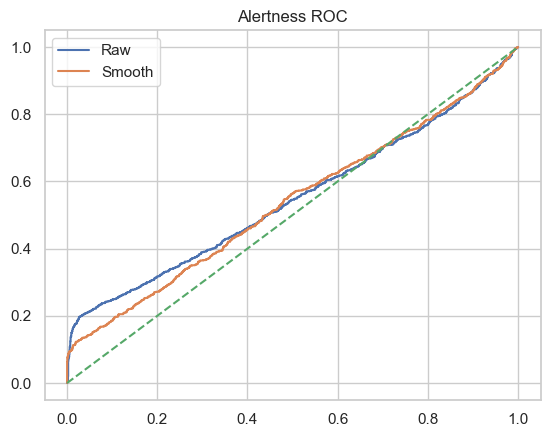

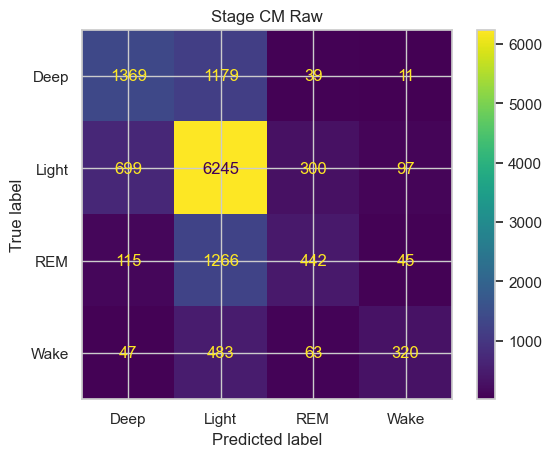

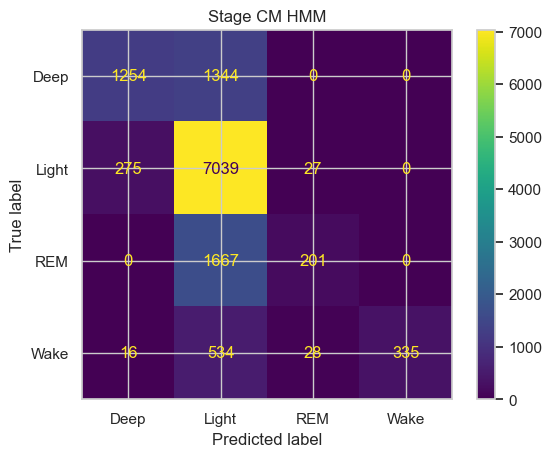

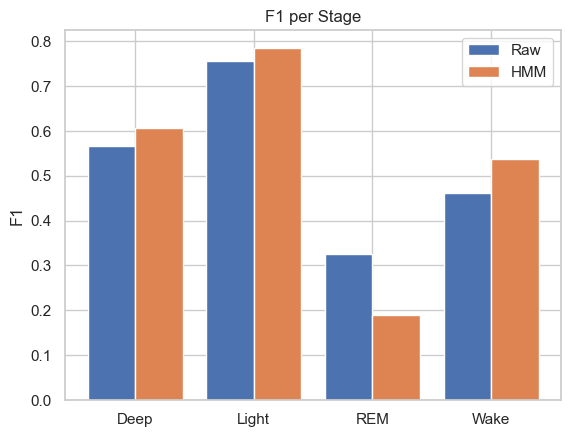

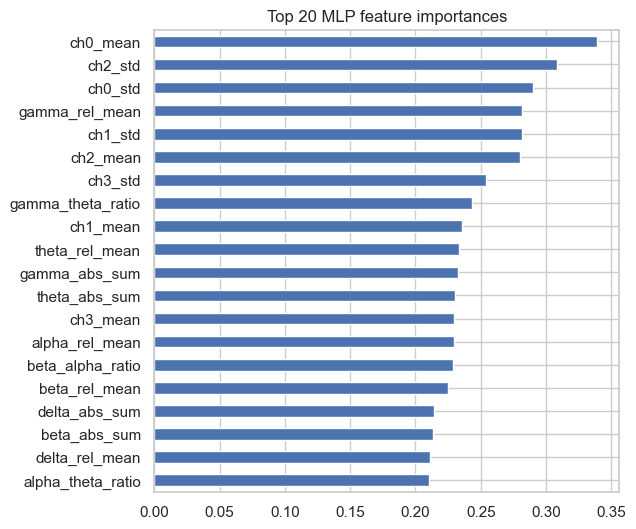

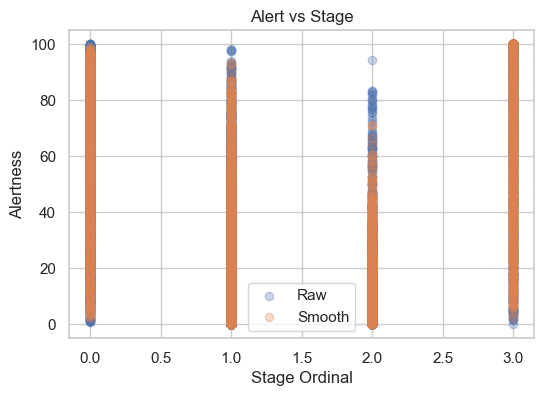

In [11]:

# ROC curves
fpr_raw, tpr_raw, _ = roc_curve((epochs.loc[mask,'stage']=='Wake').astype(int), epochs.loc[mask,'alert_mlp']/100)
fpr_sm, tpr_sm, _   = roc_curve((epochs.loc[mask,'stage']=='Wake').astype(int), epochs.loc[mask,'alert_smooth']/100)
plt.figure(); plt.plot(fpr_raw,tpr_raw,label='Raw'); plt.plot(fpr_sm,tpr_sm,label='Smooth')
plt.plot([0,1],[0,1],'--'); plt.legend(); plt.title('Alertness ROC'); plt.show()

# Confusion matrices
disp1=ConfusionMatrixDisplay.from_predictions(epochs['stage'], [STAGES[i] for i in np.argmax(probs_stage,axis=1)],labels=STAGES)
disp1.ax_.set_title('Stage CM Raw'); plt.show()
disp2=ConfusionMatrixDisplay.from_predictions(epochs['stage'], epochs['stage_hmm'],labels=STAGES)
disp2.ax_.set_title('Stage CM HMM'); plt.show()

# F1 per stage
f1_raw = f1_score(epochs['stage'], [STAGES[i] for i in np.argmax(probs_stage,axis=1)], average=None, labels=STAGES)
f1_hmm = f1_score(epochs['stage'], epochs['stage_hmm'], average=None, labels=STAGES)
plt.figure(); x=np.arange(len(STAGES))
plt.bar(x-0.2, f1_raw, width=0.4, label='Raw'); plt.bar(x+0.2, f1_hmm, width=0.4, label='HMM')
plt.xticks(x, STAGES); plt.ylabel('F1'); plt.title('F1 per Stage'); plt.legend(); plt.show()

# Feature importance from MLP (use absolute coefficients)
importances = np.mean(np.abs(mlp.coefs_[0]), axis=1)
feat_names = X.columns
fi = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(20)
plt.figure(figsize=(6,6)); fi.plot.barh(); plt.title('Top 20 MLP feature importances'); plt.gca().invert_yaxis(); plt.show()

# Scatter comparison
plt.figure(figsize=(6,4))
plt.scatter(epochs['stage_ord'], epochs['alert_mlp'], alpha=0.3, label='Raw')
plt.scatter(epochs['stage_ord'], epochs['alert_smooth'], alpha=0.3, label='Smooth')
plt.xlabel('Stage Ordinal'); plt.ylabel('Alertness'); plt.legend(); plt.title('Alert vs Stage'); plt.show()


In [ ]:

with open('mlp_alert.pkl','wb') as f: pickle.dump(mlp,f)
model.save('stage_nn.h5')
with open('hmm_params.pkl','wb') as f: pickle.dump({'trans_mat':trans_mat,'init':init_prob},f)
print('Artifacts saved.')

Artifacts saved.
